In [1]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
import torch
from functions import *
import scib_metrics
%matplotlib inline

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [20]:
adata = sc.read(
    "data/Immune_ALL_human.h5ad"
)

In [3]:
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
scanoramaPredict(adata)

Found 4000 genes among all datasets
[[0.         0.32357335 0.20456303 0.00551302 0.03270777 0.12695652
  0.0315651  0.03745318 0.0214876  0.00391389]
 [0.         0.         0.01392111 0.00537795 0.0274873  0.73855072
  0.30600614 0.38119018 0.25950413 0.        ]
 [0.         0.         0.         0.55916473 0.85382831 0.01275362
  0.00657386 0.07501933 0.02190083 0.        ]
 [0.         0.         0.         0.         0.5941807  0.01913043
  0.00526085 0.00957137 0.00398162 0.        ]
 [0.         0.         0.         0.         0.         0.06956522
  0.02235861 0.23002681 0.07506702 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.86550725 0.30318841 0.27942029 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.63875493 0.46339325 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.90719933 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.    

In [22]:
adata.write_h5ad(filename="data/adataImmHum4.h5ad")

In [2]:
adata = anndata.read_h5ad(filename="data/adataImmHum4.h5ad")
adata

AnnData object with n_obs × n_vars = 33506 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [3]:
sdnormalAdata, vaeSD = trainModelBenchmark(adata.copy(), "sdnormal", max_epochs = 200, early_stopping=True)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 155/200:  78%|███████▊  | 155/200 [04:49<01:24,  1.87s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.43e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1457.723. Signaling Trainer to stop.


In [4]:
mogAdata, vaeMG = trainModelBenchmark(adata.copy(), "mixofgaus", max_epochs = 200, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 131/200:  66%|██████▌   | 131/200 [04:45<02:30,  2.18s/it, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.43e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1477.366. Signaling Trainer to stop.


In [5]:
vampAdata, vaeVP = trainModelBenchmark(adata.copy(), "vamp", max_epochs = 200, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 194/200:  97%|█████████▋| 194/200 [07:44<00:14,  2.39s/it, v_num=1, train_loss_step=1.44e+3, train_loss_epoch=1.43e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1468.917. Signaling Trainer to stop.


In [6]:
flowAdata, vaeNF = trainModelBenchmark(adata.copy(), 'normalflow', max_epochs=100, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [14:42<00:00,  8.94s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.43e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [14:42<00:00,  8.83s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.43e+3]


In [7]:
allAdata = sdnormalAdata.copy()
allAdata.obsm["scVISD"] = sdnormalAdata.obsm["scVI"]
allAdata.obsm["scVIMG"] = mogAdata.obsm["scVI"]
allAdata.obsm["scVIVAMP"] = vampAdata.obsm["scVI"]
allAdata.obsm["scVINF"] = flowAdata.obsm["scVI"]

Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.5524995140731335
INFO:root:Erythrocytes: 0.5874729752540588
INFO:root:Erythroid progenitors: 0.6014610305428505
INFO:root:Monocyte progenitors: 0.5329934842884541
Embeddings:  20%|██        | 1/5 [06:55<27:42, 415.68s/it]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.6096711456775665
INFO:root:Erythrocytes: 0.5581997781991959
INFO:root:Erythroid progenitors: 0.5803379341959953
INFO:root:Monocyte progenitors: 0.5662365406751633
Embeddings:  40%|████      | 2/5 [07:40<09:52, 197.43s/it]INFO:root:isolated labels: no more than 3 batches per label
INFO:root:CD10+ B cells: 0.6151144355535507
INFO:root:Erythrocytes: 0.6570073217153549
INFO:root:Erythroid progenitors: 0.625655010342598
INFO:root:Monocyte progenitors: 0.5857808440923691
Embeddings:  60%|██████    | 3/5 [08:22<04:12, 126.49s/it]INFO:root:isolated labels: n

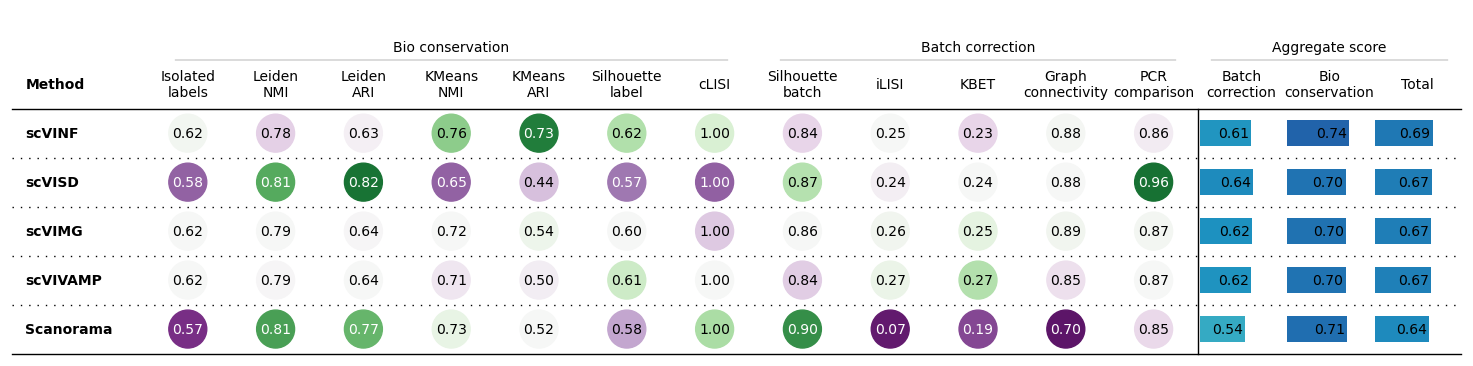

In [8]:
plotBenchmarkResults(allAdata,keys = ["Unintegrated","Scanorama","scVISD","scVIMG","scVIVAMP","scVINF"],label_key="final_annotation")